In [8]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

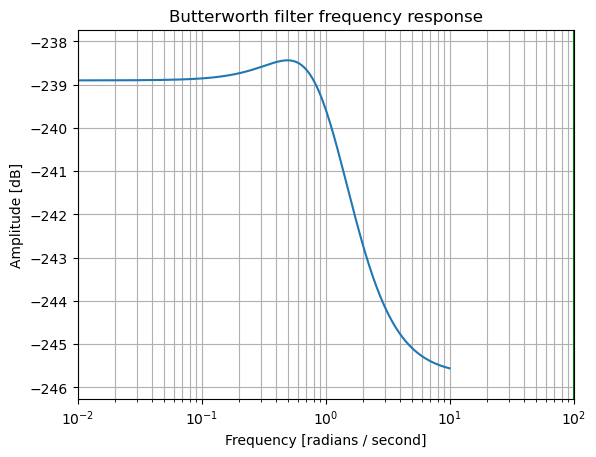

In [9]:
b, a = signal.butter(10, [8,13], 'bandpass', fs = 256)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

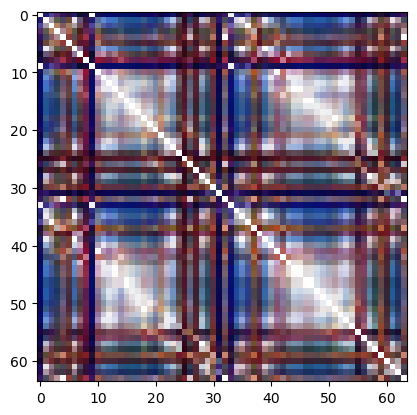

0.5201080087437232 0.19981351548395004


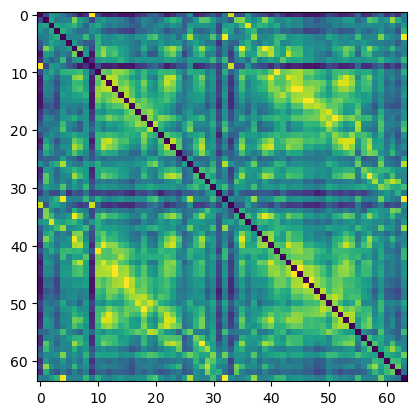

0.4073574188426946 0.21053429368835005


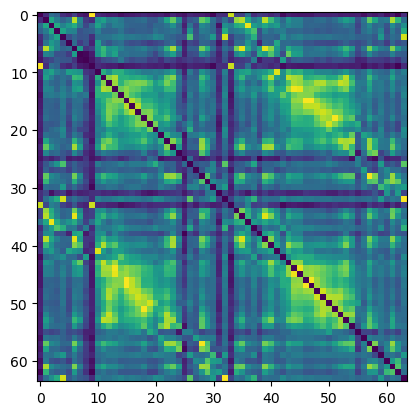

0.4966856688453127 0.2169526720370614


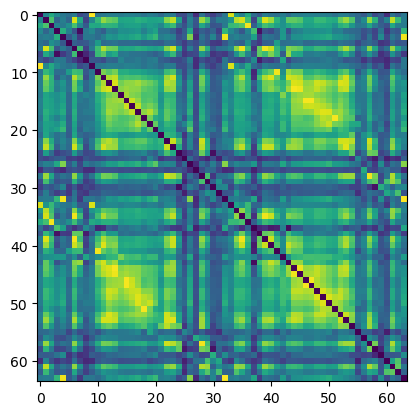

returning image
[[[0.         0.         0.        ]
  [0.21738626 0.12722507 0.4599814 ]
  [0.54377788 0.35576627 0.60723276]
  ...
  [0.23100382 0.07283818 0.38514832]
  [0.1458188  0.00696649 0.30022236]
  [0.41425229 0.12569721 0.39841251]]

 [[0.13657116 0.10801668 0.44843087]
  [0.         0.         0.        ]
  [0.57674882 0.59666354 0.7179626 ]
  ...
  [0.84222558 0.87370239 0.90024301]
  [0.61142856 0.64881795 0.67960733]
  [0.40970129 0.3613118  0.42186085]]

 [[0.30900663 0.26466967 0.62499042]
  [0.66920304 0.61225835 0.68100946]
  [0.         0.         0.        ]
  ...
  [0.51057462 0.48191785 0.60131758]
  [0.35378364 0.34059336 0.422272  ]
  [0.54464761 0.49330897 0.40640279]]

 ...

 [[0.10789531 0.06055904 0.37248064]
  [0.91160336 0.89052054 0.90181338]
  [0.57154465 0.45327139 0.54868658]
  ...
  [0.         0.         0.        ]
  [0.76518714 0.72554512 0.75440997]
  [0.43705354 0.3945421  0.38711336]]

 [[0.14129461 0.04688115 0.3218413 ]
  [0.68692314 0.59922

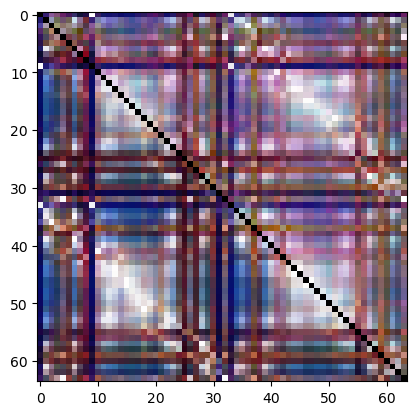

In [1]:
import numpy as np
import scipy
from global_variables import *

# retrieves the MPC(Mean Phase Coherance) feature matrix for given EEG 64 channel
def MPC(eeg):
    channels = eeg.shape[0]
    mpc_matrix = np.zeros((channels, channels), dtype=float)

    def MPC_feature(i, j):
        signal_a = np.unwrap(np.angle(scipy.signal.hilbert(eeg[i])))
        signal_b = np.unwrap(np.angle(scipy.signal.hilbert(eeg[j])))
        phase_diff = np.mean(np.exp((signal_a - signal_b) * -1j))
        return np.absolute(phase_diff)

    for i in range(channels):
        for j in range(channels):
            if i == j:
                mpc_matrix[i, j] = 0
            if i < j:
                mpc_matrix[i, j] = MPC_feature(i, j)
            else:
                mpc_matrix[i, j] = mpc_matrix[j, i]
    print(np.mean(mpc_matrix), np.std(mpc_matrix))
    return mpc_matrix


# retrieves the MSC(Magnitude Phase Coherance) feature matrix for given EEG 64 channel
def MSC(eeg):
    channels = eeg.shape[0]
    msc_matrix = np.zeros((channels, channels, 3), dtype=float)
    for i in range(channels):
        for j in range(channels):
            if i <= j:
                temp = scipy.signal.coherence(
                    eeg[i], eeg[j], window = scipy.signal.windows.hamming(51) , nfft = 256, fs=256)
                t1 = (temp[0] <= 8).astype(bool)
                t2 = (temp[0] <= 13).astype(bool)
                t3 = (temp[0] <= 30).astype(bool)
                t4 = (temp[0] <= 70).astype(bool)
                alpha = np.mean(temp[1][~t1 & t2])
                beta = np.mean(temp[1][~t2 & t3])
                gamma = np.mean(temp[1][~t3 & t4])
                msc_matrix[i,j,0] = alpha
                msc_matrix[i,j,1] = beta
                msc_matrix[i,j,2] = gamma
            else:
                msc_matrix[i, j, 0] = msc_matrix[j, i, 0]
                msc_matrix[i, j, 1] = msc_matrix[j, i, 1]
                msc_matrix[i, j, 2] = msc_matrix[j, i, 2]
    return msc_matrix


# alpha beta gamma filtering for every eeg electrode
def alpha_beta_gamma_extractor(eeg):
    a = scipy.signal.butter(10, [8, 13], 'bandpass', fs=256, output='sos')
    b = scipy.signal.butter(10, [13, 30], 'bandpass', fs=256, output='sos')
    g = scipy.signal.butter(10, [30, 70], 'bandpass', fs=256, output='sos')

    alpha = scipy.signal.sosfilt(a, eeg, axis = 1)
    beta = scipy.signal.sosfilt(b, eeg, axis = 1)
    gamma = scipy.signal.sosfilt(g, eeg, axis = 1)

    return [alpha, beta, gamma]


# reutrn Image form of the eeg from alpha beta gamma bands and MPC and MSC feature matrix
def EEG_Image(eeg, **kwargs):
    eeg_channles = alpha_beta_gamma_extractor(eeg)
    Image = MSC(eeg)
    plt.imshow(Image)
    plt.show()
    for i in range(3):
        eeg_mpc = MPC(eeg_channles[i])
        plt.imshow(eeg_mpc)
        plt.show()
        n = eeg_mpc.shape[0]
        for p in range(n):
            Image[p,p,i] = 0
            for q in range(p + 1, n):
                Image[p, q, i] = eeg_mpc[p, q]
    return Image


if __name__ == "__main__":
    from pre_processing import load_EEG
    from PIL import Image
    import matplotlib.pyplot as plt


    eeg_path, label = load_EEG("Long_words", 2)
    eeg = eeg_path[0]
    with open(eeg, 'rb') as f:
        eeg = np.load(f)
    alpha, beta, gamma = alpha_beta_gamma_extractor(eeg)

    img = EEG_Image(eeg)

    print("returning image")
    print(img)
    plt.imshow(img)
    plt.show()

    # print(EEG_Image(eeg)[:,:,0])
